In [1]:
%load_ext autoreload
%autoreload 2

# Doc-ID Reassignment

## 1. Data download

### Downloader instance

We download [RCV1 dataset](https://paperswithcode.com/dataset/rcv1), in particular we use tf-idf representation from [sklearn](https://scikit-learn.org/0.18/datasets/rcv1.html).

Create an instance of downloader.

In [2]:
from model.rcv1 import RCV1Downloader

downloader = RCV1Downloader()
downloader

RCV1Downloader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz; Downloaded: True]

### Download

Download the dataset.

In [3]:
%%time

downloader.download()

INFO: Dataset is already downloaded at /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz
CPU times: user 223 µs, sys: 52 µs, total: 275 µs
Wall time: 239 µs


## 2. Data Loading

### Loading collection configurations

Use dataset configuration specified in the *.settings.py* file.

In [4]:
from settings import DATACONFIG

config = DATACONFIG["tiny"]
config

tiny [Docs: 50000; Terms: 15000; Approximation error: 0.3; N Clusters: 150]

### Loader instance

Create an instance of dataloader.

In [5]:
from model.rcv1 import RCV1Loader

loader = RCV1Loader()
loader

RCV1Loader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz]

### Load

We load data sorting terms by decreasing frequency.

We only keep the first documents and terms specified by the configuration file.

In [6]:
collection = loader.load(n_docs=config.docs, n_terms=config.terms)

In [7]:
collection

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

## 3. Computing *d*-gap

### *d*-gap instance

Create and instance of DGapComputation for the collection.

In [8]:
from model.d_gap import DGapComputation

dgap = DGapComputation(collection=collection, data_name=config.name)
dgap

DGapComputation(tiny)[Docs: 50000; Terms: 14980; Computed: False]

### Compute *d*-gap statistics

We compute *d*-gap in the given collection.

In [9]:
%%time

dgap.compute_d_gaps()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap.json. 
INFO: Computing average d-gap per term. 


100%|██████████| 50000/50000 [00:02<00:00, 18776.66it/s]

CPU times: user 2.67 s, sys: 7.6 ms, total: 2.68 s
Wall time: 2.67 s


In [10]:
avg_d_gaps = dgap.avg_d_gap_pterm
avg_d_gaps

array([12.87289, 13.70597, 13.79   , ..., 72.     , 80.     , 88.     ])

### Average *d*-gap per term plot

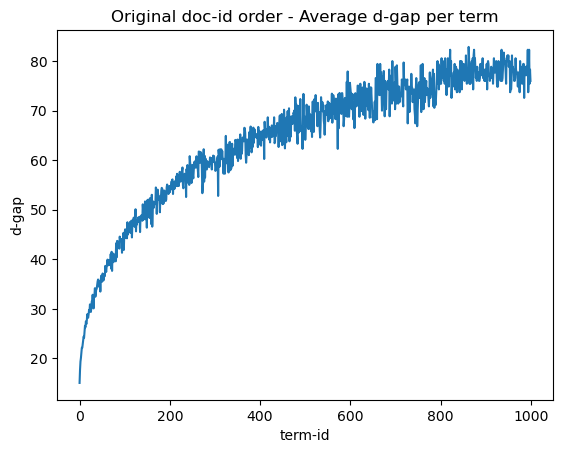

In [11]:
dgap.plot_avg_d_gap()

### Average *d*-gap

In [12]:
dgap.avg_d_gap

65.23313317089453

### Save statistics

We save statistics with in the directory with the specific configuration name: it will be no more necessary a second computation for further analysis.

In [13]:
dgap.save_d_gaps()

INFO: Saving average d-gap per term to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap.json. 


## 4. Dimensionality reduction

Clustering and TSP are expensive in a high dimensional and sparse vector space. We employ the [Johnson-Lindenstrauss lemma](https://scikit-learn.org/stable/modules/random_projection.html#the-johnson-lindenstrauss-lemma) to embed data points in a lower dense dimensional space through a random projection. Target dimension depends on an approximation factor specified in Dataset configuration.

### Approximation factor

The approximation factor is in range [0, 1]

In [14]:
eps = config.eps
eps

0.3

Project to embedded space.

In [15]:
embedded = collection.embed(eps=eps)
embedded.shape

(50000, 1202)

## 5. Clustering

### Compute number of clusters

We compute the number of cluster to find using a function specified in the configuration.

In [16]:
n_cluster = config.n_cluster
n_cluster

150

### Create K-Means instance

In [17]:
from model.clustering import KMeansClustering

kmeans = KMeansClustering(mat=embedded, data_name=config.name, k=n_cluster)

In [18]:
kmeans

KMeansClustering(tiny)[Items: 50000; k: 150; Labeling computed: False]

### Training model and retrieve labeling

In [19]:
%%time

kmeans.fit()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json. 
INFO: Fitting K-Means model. 
CPU times: user 2min 51s, sys: 10.2 s, total: 3min 1s
Wall time: 53.2 s


In [20]:
labeling = kmeans.labeling

labeling

array([ 81, 134,  58, ...,  19,   7,   7], dtype=int32)

### Save labeling

We save labeling on disk so we don't necessitate to compute again for further needs.

In [21]:
kmeans.save_labeling()

INFO: Saving labeling to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json. 


## 6. Cluster split

### Get CollectionCluster instance

We split data in cluster using the labeling.

In [22]:
collection_clusters = kmeans.clusters

In [23]:
collection_clusters

RCV1Clusters(tiny)[Data: 50000, Clusters: 150, Mean-per-Cluster: 333.333; Medoids computed: False]

### Compute medoids

In [24]:
%%time

collection_clusters.compute_medoids()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 
INFO: Computing medoids. 


100%|██████████| 150/150 [00:00<00:00, 2535.77it/s]

CPU times: user 54.9 ms, sys: 11.9 ms, total: 66.8 ms
Wall time: 65.5 ms


In [25]:
medoids = collection_clusters.medoids

medoids.shape

(150, 1202)

In [26]:
medoids

array([[-9.25878846e-04,  1.54320630e-04, -1.09512301e-03, ...,
         1.38765051e-03, -8.98959735e-05, -4.69709114e-03],
       [ 2.39897686e-04,  0.00000000e+00, -3.76215183e-02, ...,
         2.80822179e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.09241788e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.51069710e-04, -2.22859193e-03, -6.81003396e-04, ...,
        -6.04688288e-04, -3.22836424e-03, -1.81424460e-02],
       [ 3.41880346e-04, -1.18880201e-04, -1.01506001e-03, ...,
         3.02638324e-03,  2.12864140e-03, -1.33085393e-03]])

### Save medoids

Save medoids on disk.

In [27]:
collection_clusters.save_medoids()

INFO: Saving medoids to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 


## 7. doc-*ID* reassignment

In [28]:
from model.reassignment import DocIdReassignmentComputation

reassignment_computation = DocIdReassignmentComputation(
    cluster=collection_clusters,
    data_name=config.name
)

reassignment_computation

INFO: Medoids already computed. Use `medoids` to retrieve them. 


DocIdReassignmentComputation(tiny)[]

In [29]:
reassignment_computation.solve()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/reassignment_order.json. 
INFO: Solving TSP over medoids 
INFO: Solving TSP. 
INFO: Solving cluster internal order


100%|██████████| 150/150 [00:00<00:00, 231.44it/s]


In [30]:
reassignment_computation.medoids_order

array([  2, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138,
       137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125,
       124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112,
       111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,
        98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,
        85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,
        72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,
        59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   1,   0])

In [31]:
reassignment_computation.cluster_order

{0: array([ 244, 1094,  253, ...,  887, 1061,  995]),
 1: array([51, 71, 60, 31, 32, 75,  4, 67, 25, 61, 88, 26, 69,  8, 72, 79, 68,
        70, 11, 76, 12, 36, 41, 37, 86,  2, 30, 83, 57, 35, 27, 18, 49,  1,
        19, 43, 22, 10, 38,  9, 13, 59, 42, 58, 20, 62, 56,  7, 28,  6, 15,
         0, 54, 63, 23, 50, 39, 92,  3, 17, 16, 14, 24, 21, 46, 53, 65, 80,
        40,  5, 55, 29, 82, 34, 74, 47, 77, 81, 45, 52, 90, 33, 84, 73, 64,
        48, 87, 44, 78, 89, 85, 91, 66]),
 2: array([ 8, 11, 10, 14, 13,  9, 15, 16, 17, 12,  6,  5,  7,  4,  2,  1,  0,
         3]),
 3: array([20, 28, 33, 25, 21, 32, 30, 24, 35, 22,  6, 19, 29,  0, 27,  9, 31,
         3, 11, 15, 23, 34, 26, 36,  7,  1, 10, 17,  4, 14,  8, 18,  5, 12,
        16, 13,  2]),
 4: array([31,  4,  9, 57, 52, 33, 68, 50, 29, 61, 56, 49, 35, 27, 26, 63, 73,
        74,  0,  6, 11, 16, 23, 22, 40, 39,  5, 51, 66,  3, 71, 67, 32, 53,
        20, 18, 45, 43, 54, 48, 42, 17, 60, 58, 69, 44,  2, 70, 41, 21, 62,
        10, 72, 37, 

In [32]:
reassignment_computation.save_order()

INFO: Saving medoids and cluster order to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/reassignment_order.json 


In [33]:
from model.reassignment import DocIdReassignment

docs_reassignment = DocIdReassignment(
    collection=collection,
    labeling=labeling,
    medoids_order=reassignment_computation.medoids_order,
    clusters_order=reassignment_computation.cluster_order,
    data_name=config.name
)

docs_reassignment

DocIdReassignment[Items: 50000]

In [34]:
collection_reass = docs_reassignment.reassign_doc_id()

collection_reass

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

In [35]:
from model.d_gap import DGapComputationReassigned

dgap_reass = DGapComputationReassigned(collection=collection_reass, data_name=config.name)
dgap_reass

DGapComputation(tiny)[Docs: 50000; Terms: 14980; Computed: False]

In [36]:
dgap_reass.compute_d_gaps()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap_reassigned.json. 
INFO: Computing average d-gap per term. 


100%|██████████| 50000/50000 [00:02<00:00, 17912.41it/s]


## 8. Inference

In [37]:
from model.d_gap import DGapInference

inference = DGapInference(d_gap_original=dgap, d_gap_reassigned=dgap_reass)
inference

INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 
INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 


DGapInference[Terms: 14980]

In [44]:
inference.avg_compression

9.563052687654361